In [3]:
# For data handling we use pandas and numpy
# For visualization we use matplotlib and seaborn
# these are foundational tools for loading, manipulating, summarizing, and visualizing datasets in almost every ML workflow.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
# Supress noisy warnings and set consistent seaborn style
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [5]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("./data/AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Display DataFrame info summary, including data types and non-null counts
# Helps identify missing values, proper dtypes (numeric vs object), and memory considerations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# List column names
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
# Count occurrences of each class in the target variable 'isFraud'
# Shows class imbalance (fraud vs non-fraud). Knowing imbalance is crucial because it affects model choice, 
# evaluation metrics, and sampling strategies.
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [9]:
# Helps understand related flags/indicators
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
# Count total missing values in the whole DataFrame
# Quick health check to decide whether imputation or row/column removal is needed prior to modeling.
df.isnull().sum().sum()

np.int64(0)

In [11]:
# Show dataset dimensions (rows, columns)
# To know dataset size which influences training time, memory, and statistical stability.
df.shape

(6362620, 11)

In [12]:
# Compute percentage of fraud cases in the dataset (fraud prevalence).
# Percent fraud quantifies imbalance and informs thresholds for oversampling/undersampling or metric choice like precision/recall.
round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100, 2)

np.float64(0.13)

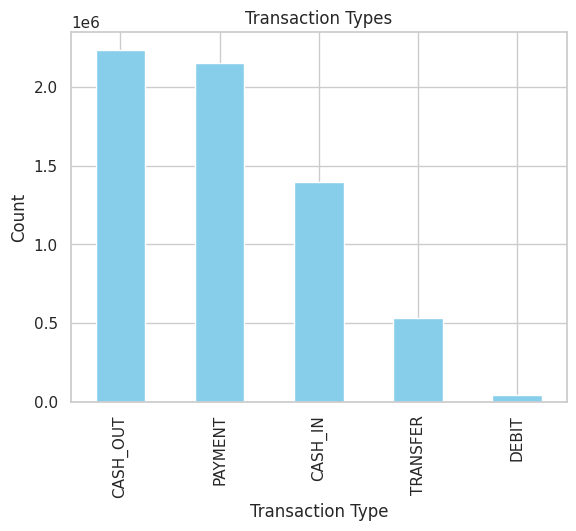

In [13]:
# Bar chart of transaction type frequencies
# Helps spot dominant transaction types and whether some types are rare, useful for feature selection/encoding
df["type"].value_counts().plot(kind="bar", title="Transaction Types", color="skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

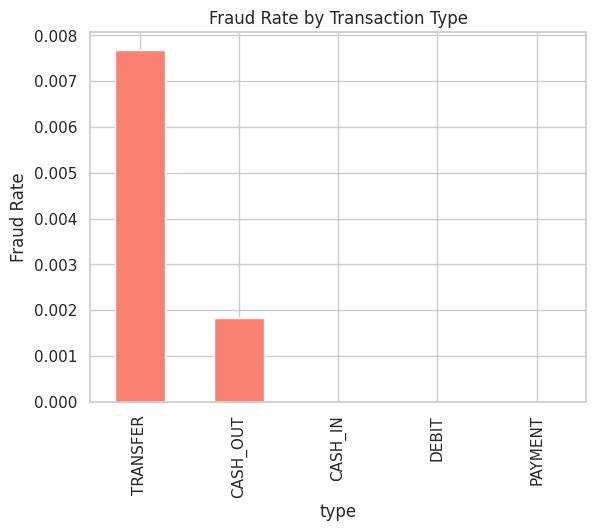

In [14]:
# Compute and plot fraud rate per transaction type (mean of isFraud per type).
# Identifies which transaction types are riskier, valuable for feature engineering and domain interpretation
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Transaction Type", color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [15]:
# Show descriptive stats (count, mean, std, min, quartiles, max) for amount, cast to int for readability.
# Reveals scale, outliers, and distribution shape — guides transforms (log, clipping) and scaling decisions.
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

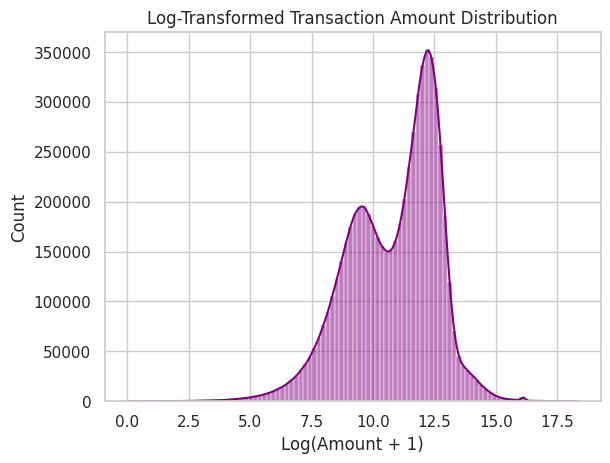

In [16]:
# Visualize the log-transformed amount distribution with KDE
# Transaction amounts are typically skewed; log transform normalizes distribution, improving model stability 
# and assumptions for algorithms that prefer symmetric features.
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color="purple")
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("Log(Amount + 1)")
plt.show()

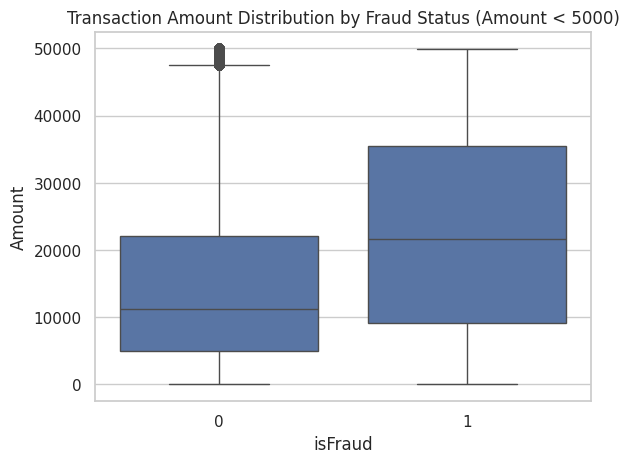

In [17]:
# Boxplot of amount by fraud status, limited to amounts below a threshold to avoid extreme outlier domination.
# Compares typical amounts for fraud vs non-fraud; can reveal whether frauds use notably different amounts, suggesting amount is predictive
sns.boxplot(data = df[df["amount"] < 50000], x="isFraud", y="amount")
plt.title("Transaction Amount Distribution by Fraud Status (Amount < 5000)")
plt.ylabel("Amount")
plt.show()

In [18]:
# Create two engineered features representing balance changes for origin and destination accounts
# Raw balances are less informative than the change; engineered differences often capture the transaction 
# effect and can be strong predictors.
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [19]:
# Count cases where origin balance decreased by a negative amount (unexpected negative diff)
# Helps detect inconsistencies or errors in data and potential anomalous behavior — useful for data cleaning or flag features
(df["balanceDiffOrig"] < 0).sum()

np.int64(1399253)

In [20]:
# Count destination negative differences.
# Verify data consistency and find suspicious records
(df["balanceDiffDest"] < 0).sum()

np.int64(1238864)

In [21]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


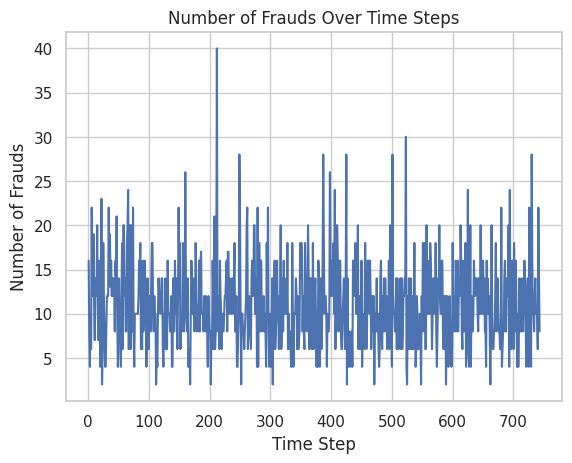

In [22]:
# Visualize fraud counts over the step time variable
# Examines temporal patterns (peaks, trends) which can inform time-based features, seasonality handling, or train/test split strategies
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.title("Number of Frauds Over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Number of Frauds")
plt.grid(True)
plt.show()

In [23]:
# Either step was deemed irrelevant, leaking, or not useful for modeling (or was only used for the earlier visualization). 
# Dropping reduces noise; ensure no leakage before dropping
df.drop(columns="step", inplace=True)

In [24]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [25]:
# compute the top 10 most frequent sender ID
# understanding heavy senders can indicate hubs, bots, or anomalies; also helps decide whether to encode these IDs or aggregate them rather than use 
# raw high-cardinality string IDs
top_senders = df["nameOrig"].value_counts().head(10)

In [26]:
top_senders

nameOrig
C1530544995    3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1065307291    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [27]:

top_receivers = df["nameDest"].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [28]:
#Purpose: top senders among fraud cases.
#Why it's needed: identifies suspicious accounts disproportionately involved in fraud — could become a high-signal categorical feature (or used to blacklist).
fraud_users = df[df["isFraud"] == 1]['nameOrig'].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
C1364127192    1
Name: count, dtype: int64

In [29]:
#Purpose: filter dataset for transaction types TRANSFER and CASH_OUT.
#Why it's needed: these types are commonly associated with fraud
fraud_types = df[df["type"].isin(["TRANSFER", "CASH_OUT"])]

In [41]:
fraud_types.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


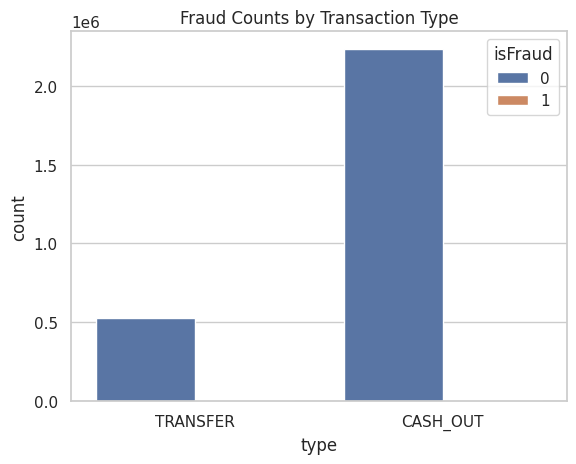

In [30]:
# Purpose: stacked/side-by-side counts of fraud vs non-fraud for the selected types.
# Why it's needed: visualizes how fraud proportion differs between TRANSFER and CASH_OUT; helps prioritize features or targeted models per type.
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title("Fraud Counts by Transaction Type")
plt.show()

In [31]:
# Purpose: compute correlation matrix among selected numeric features including the target.
# Why it's needed: correlation can highlight which numeric features are linearly associated with isFraud; helps feature selection and multicollinearity checks.
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


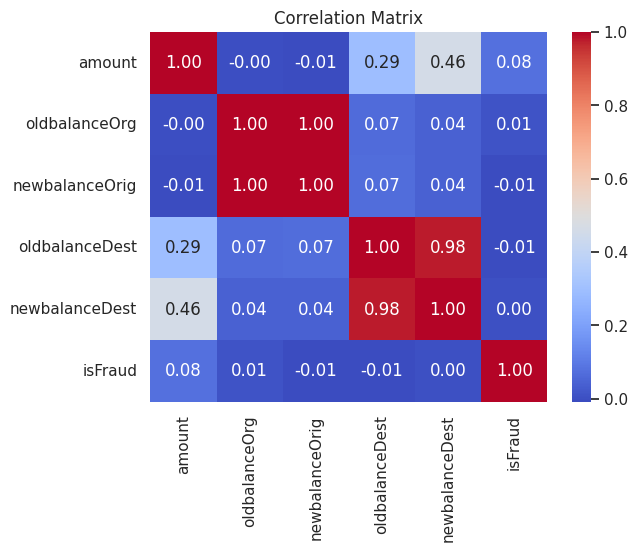

In [32]:
# Purpose: visualize the correlation matrix with annotations.
# Why it's needed: easier visually to spot strong positive/negative correlations; guides which features to scale, transform, or drop.
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [33]:
# Purpose: create a subset where origin had positive balance but new origin balance is zero after a TRANSFER/CASH_OUT.
# Why it's needed: suspicious pattern that often indicates fraudulent behavior (draining account). 
# Such logical rules can be turned into binary features (flags) that models use effectively.
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0) &
    (df["newbalanceOrig"] == 0) &
    (df["type"].isin(["TRANSFER", "CASH_OUT"]))
]

In [34]:
len(zero_after_transfer)

1188074

In [35]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [36]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [38]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [39]:
df_model = df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)

In [40]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [ ]:
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]


In [45]:
y = df_model["isFraud"]
X = df_model.drop("isFraud", axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [52]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000))
])

In [53]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [56]:
y_pred = pipeline.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [58]:
confusion_matrix(y_test, y_pred)

array([[1805700,  100622],
       [    151,    2313]])

In [60]:
pipeline.score(X_test, y_test) * 100

94.72057108549623

In [61]:
import joblib
joblib.dump(pipeline, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']